In [2]:
import numpy as np
from spec_id import Analyze_Stack_avgage,Likelihood_contours, Make_model_list,\
    Stack_spec_normwmean,Stack_model_normwmean,Best_fit_model,Model_fit_stack_UVB_normwmean
import matplotlib.pyplot as plt
import vtl.Constants as C
from vtl.Readfile import Readfile
from vtl.Get_sensitivity import Get_Sensitivity
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d,interp2d
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [4]:
ids,speclist,lmass,rshift,rad,sig,comp=np.array(Readfile('masslist_feb28.dat',is_float=False))
lmass,rshift,rad,sig,comp=np.array([lmass,rshift,rad,sig,comp]).astype(float)

IDc=[]  # low mtor sample
IDd=[]  # high mtor sample

IDmL=[]  # low mass sample
IDmH=[]  # high mass sample

for i in range(len(ids)):
    if 0.14 < comp[i] and 1 < rshift[i] < 1.75:
        IDd.append(i)
    if 0.14 > comp[i] and 1 < rshift[i] < 1.75:
        IDc.append(i)
    if 10.931 > lmass[i] and 1 < rshift[i] < 1.75:
        IDmL.append(i)
    if 10.931 < lmass[i] and 1 < rshift[i] < 1.75:
        IDmH.append(i)

metal=np.array([ 0.0020, 0.0025, 0.0031, 0.0039, 0.0049, 0.0061,  0.0068,  0.0077,  0.0085,  0.0096,  0.0106,
                  0.012, 0.0132, 0.014,  0.0150,  0.0164, 0.018,  0.019,  0.021,  0.024, 0.027, 0.03])
bcmetal=np.array([0.0001, 0.0004, 0.004, 0.008, 0.02])
age=np.arange(.5,6.1,.1)
tau=[0,8.0,8.15,8.28,8.43,8.57,8.72,8.86,9.0,9.14,9.29,9.43,9.57,9.71,9.86,10.0]

M,A=np.meshgrid(metal,age)
BM,BA=np.meshgrid(bcmetal,age)

In [24]:
def Model_fit_stack_normwmean_features(speclist, tau, metal, A, speczs,ids, wv_range, name, pkl_name, res=5, fsps=True):
    ##############Stack spectra################
    wv, fl, er = Stack_spec_normwmean(speclist, speczs, wv_range)
    IDM=[]
    for i in range(len(wv)):
        if 3800<=wv[i]<=3850 or 3910<=wv[i]<=4030 or 4080<=wv[i]<=4125 or 4250<=wv[i]<=4385 or 4515<=wv[i]<=4570 or 4810<=wv[i]<=4910 or 4975<=wv[i]<=5055 or 5110<=wv[i]<=5285:
            IDM.append(i)  


    #############Prep output file###############

    chifile = 'chidat/%s_chidata.fits' % name
    prihdr = fits.Header()
    prihdu = fits.PrimaryHDU(header=prihdr)
    hdulist = fits.HDUList(prihdu)

    ###############Pickle spectra##################

    pklname = 'pickled_mstacks/%s.pkl' % pkl_name

    if os.path.isfile(pklname) == False:

        pklspec = open(pklname, 'wb')

        for i in range(len(metal)):
            for ii in range(len(A)):
                for iii in range(len(tau)):
                    if fsps == True:
                        mlist=Make_model_list(ids,metal[i],A[ii],tau[iii],speczs)
                    else:
                        mlist=Make_model_list(ids,metal[i],A[ii],tau[iii],speczs,fsps=False)
                    mw, mf = Stack_model_normwmean(speclist, mlist, speczs, np.arange(wv[0], wv[-1] + res, res))
                    cPickle.dump(mf, pklspec, protocol=-1)

        pklspec.close()

        print 'pickle done'

    ##############Create chigrid and add to file#################

    outspec = open(pklname, 'rb')

    mf = []
    for i in range(len(metal)):
        for ii in range(len(A)):
            for iii in range(len(tau)):
                mf.append(cPickle.load(outspec)[IDM])

    mf = np.array(mf)

    outspec.close()

    chigrid = np.sum(((fl[IDM] - mf) / er[IDM]) ** 2, axis=1).reshape([len(metal), len(A), len(tau)])

    ###############
    for i in range(len(metal)):
        inputgrid = np.array(chigrid[i])
        spc = 'metal_%s' % metal[i]
        mchi = fits.ImageHDU(data=inputgrid, name=spc)
        hdulist.append(mchi)

    ################Write chigrid file###############

    hdulist.writeto(chifile)
    return

0.00484243629501
--


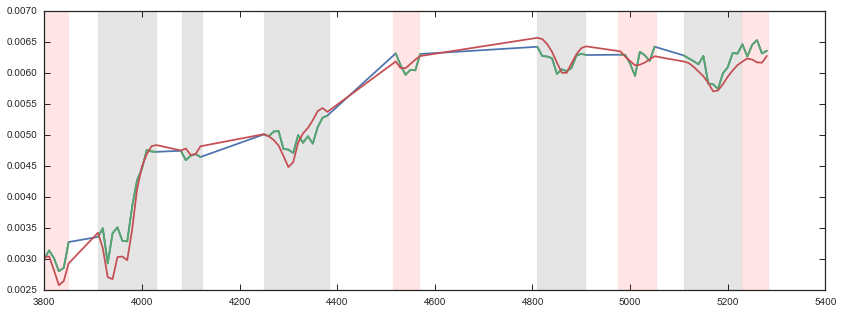

In [18]:
%matplotlib inline

wv,fl,er=Stack_spec_normwmean(speclist[IDc],rshift[IDc],np.arange(3250,5350,10))
mlist=Make_model_list(ids[IDc],0.0132,3.5,0,rshift[IDc])
mwv,mfl=Stack_model_normwmean(speclist[IDc],mlist,rshift[IDc],np.arange(wv[0],wv[-1]+10,10)) 

IDM=[]
for i in range(len(wv)):
    if 3800<=wv[i]<=3850 or 3910<=wv[i]<=4030 or 4080<=wv[i]<=4125 or 4250<=wv[i]<=4385 or 4515<=wv[i]<=4570 or 4810<=wv[i]<=4910 or 4975<=wv[i]<=5055 or 5110<=wv[i]<=5285:
        IDM.append(i)  


plt.figure(figsize=[14,5])
plt.plot(wv[IDM],fl[IDM])
plt.plot(mawv,mafl)
plt.plot(mwv[IDM],mfl[IDM])
plt.axvspan(3800, 3850, color='r', alpha=.1)
plt.axvspan(3910, 4030, color='k', alpha=.1)
plt.axvspan(4082, 4125, color='k', alpha=.1)
plt.axvspan(4250, 4385, color='k', alpha=.1)
plt.axvspan(4515, 4570, color='r', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(4975, 5055, color='r', alpha=.1)
plt.axvspan(5110, 5230, color='k', alpha=.1)
plt.axvspan(5230, 5285, color='r', alpha=.1)
plt.show()
plt.close()

0.0132 3.4 0
Best fit model is 3.5 Gyr and 0.0132 Z

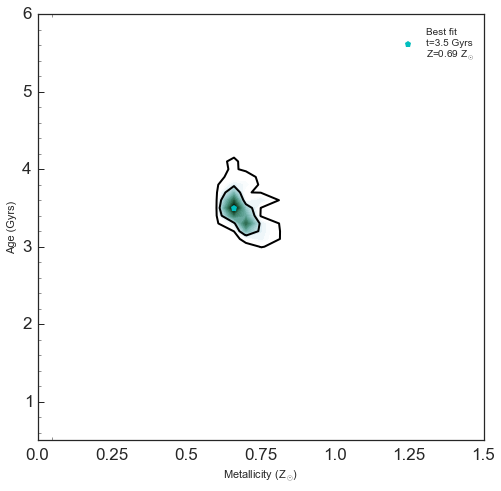

0.0106 5.9 8.57
Best fit model is 4.9 Gyr and 0.012 Z

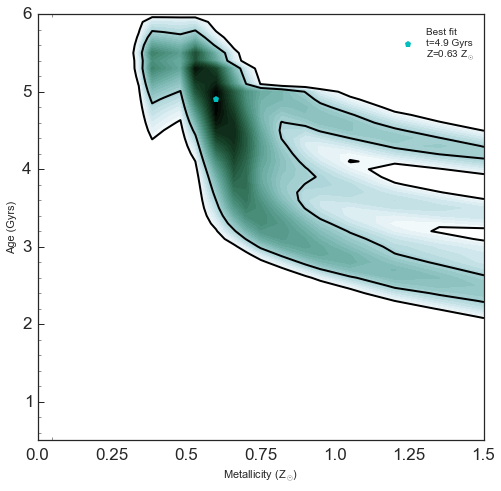

[[30 12]]


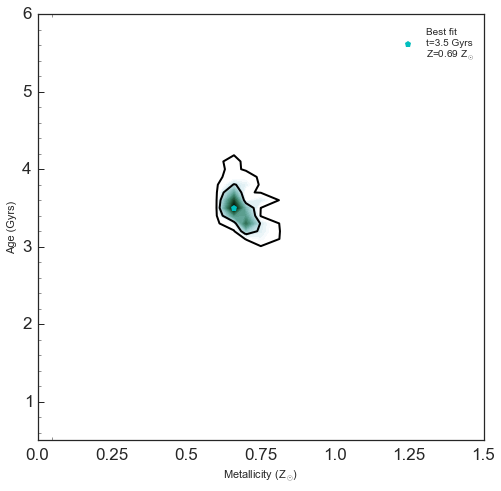

In [39]:
# Model_fit_stack_normwmean_features(speclist[IDc],tau,metal,age,rshift[IDc],ids[IDc],np.arange(3250,5350,10),'com_feat_mar3_fit',
#                           'com_feb27_spec',res=10,fsps=True)
bfm,bfa,bft=Best_fit_model('chidat/com_feat_mar3_fit_chidata.fits',metal,age,tau)
Pr, bfage, bfmetal= Analyze_Stack_avgage('chidat/com_feat_mar3_fit_chidata.fits',np.array(tau),metal,age)
# onesig,twosig=Likelihood_contours(age,metal,Pr)
# levels=np.array([twosig,onesig])
# print levels
levels=np.array([30.90866543, 322.16339735])

plt.figure(figsize=[8,8])
plt.contour(M,A,Pr,levels,colors='k',linewidths=2)
plt.contourf(M,A,Pr,40,cmap=colmap)
plt.plot(bfmetal,bfage,'cp',label='\nBest fit\nt=%s Gyrs\nZ=%s Z$_\odot$' % (bfage,np.round(bfmetal/0.019,2)))
plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
plt.tick_params(axis='both', which='major', labelsize=17)
plt.gcf().subplots_adjust(bottom=0.16)
plt.minorticks_on()
plt.xlabel('Metallicity (Z$_\odot$)')
plt.ylabel('Age (Gyrs)')
plt.legend()
plt.show()
plt.close()

bfm,bfa,bft=Best_fit_model('chidat/com_uvb_marc3_fit_chidata.fits',metal,age,tau)
Pru, bfage, bfmetal= Analyze_Stack_avgage('chidat/com_uvb_marc3_fit_chidata.fits',np.array(tau),metal,age)
# onesig,twosig=Likelihood_contours(age,metal,Pr)
# levels=np.array([twosig,onesig])
# print levels
levels=np.array([6.18360513, 15.93924044])

plt.figure(figsize=[8,8])
plt.contour(M,A,Pru,levels,colors='k',linewidths=2)
plt.contourf(M,A,Pru,40,cmap=colmap)
plt.plot(bfmetal,bfage,'cp',label='\nBest fit\nt=%s Gyrs\nZ=%s Z$_\odot$' % (bfage,np.round(bfmetal/0.019,2)))
plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
plt.tick_params(axis='both', which='major', labelsize=17)
plt.gcf().subplots_adjust(bottom=0.16)
plt.minorticks_on()
plt.xlabel('Metallicity (Z$_\odot$)')
plt.ylabel('Age (Gyrs)')
plt.legend()
plt.show()
plt.close()
# 
Prt=Pr*Pru
Age=[]
for i in range(len(Prt)):
    Age.append(np.trapz(Prt[i],metal))
    
C=np.trapz(Age,age)
Prt/=C

# onesig,twosig=Likelihood_contours(age,metal,Prt)
# levels=np.array([twosig,onesig])
# print levels
x=np.argwhere(Prt==np.max(Prt))

print x
bfmetal,bfage=[metal[x[0][1]],age[x[0][0]]]

levels=np.array([31.62749269, 310.47171728])

plt.figure(figsize=[8,8])
plt.contour(M,A,Prt,levels,colors='k',linewidths=2)
plt.contourf(M,A,Prt,40,cmap=colmap)
plt.plot(bfmetal,bfage,'cp',label='\nBest fit\nt=%s Gyrs\nZ=%s Z$_\odot$' % (bfage,np.round(bfmetal/0.019,2)))
plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
plt.tick_params(axis='both', which='major', labelsize=17)
plt.gcf().subplots_adjust(bottom=0.16)
plt.minorticks_on()
plt.xlabel('Metallicity (Z$_\odot$)')
plt.ylabel('Age (Gyrs)')
plt.legend()
plt.show()
plt.close()

0.012 3.2 8.15
0.03

 6.0 9.29


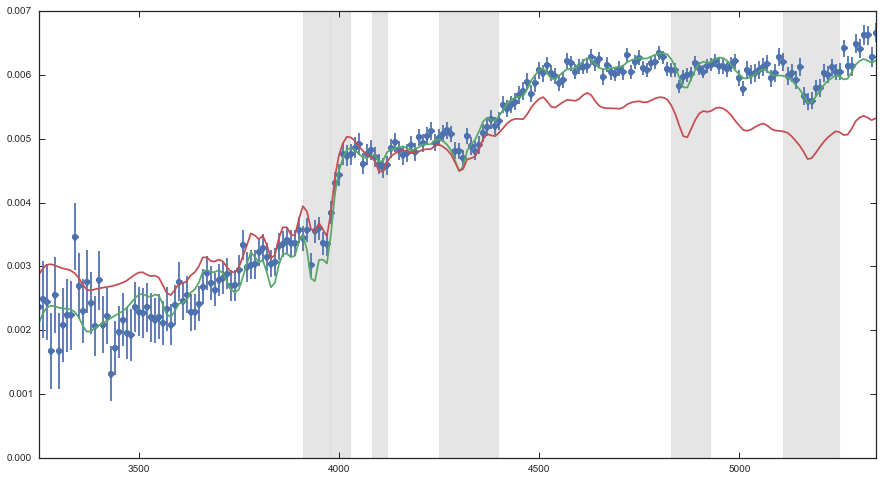

In [42]:
wv, fl, er = Stack_spec_normwmean(speclist[IDmH], rshift[IDmH], np.arange(3250, 5350, 10))
bfm, bfa, bft = Best_fit_model('chidat/gt10.93_feb27_fit_chidata.fits', metal, age, tau)
blist = Make_model_list(ids[IDmH], bfm, bfa, bft, rshift[IDmH])
bwv, bfl = Stack_model_normwmean(speclist[IDmH], blist, rshift[IDmH], np.arange(wv[0], wv[-1] + 10, 10))

nfm, nfa, nft = Best_fit_model('chidat/gt10.93_nc_feb27_fit_chidata.fits', metal, age, tau)
nlist = Make_model_list(ids[IDmH], nfm, nfa, nft, rshift[IDmH])
nwv, nfl = Stack_model_normwmean(speclist[IDmH], nlist, rshift[IDmH], np.arange(wv[0], wv[-1] + 10, 10))

plt.figure(figsize=[15, 8])
plt.errorbar(wv, fl, er, fmt='o')
plt.plot(bwv, bfl)
plt.plot(nwv, nfl)
plt.axvspan(3910, 3979, color='k', alpha=.1)
plt.axvspan(3981, 4030, color='k', alpha=.1)
plt.axvspan(4082, 4122, color='k', alpha=.1)
plt.axvspan(4250, 4400, color='k', alpha=.1)
plt.axvspan(4830, 4930, color='k', alpha=.1)
plt.axvspan(5109, 5250, color='k', alpha=.1)
plt.xlim(min(wv), max(wv))
plt.show()
plt.close()